In [ ]:
#@title Connecting to google drive for files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Importing necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import functools, re
import random

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#@title Loading texts data from CSV file with 47692 rows × 2 columns
df = pd.read_csv("/content/drive/My Drive/Project/twitter.csv")
df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


<AxesSubplot:>

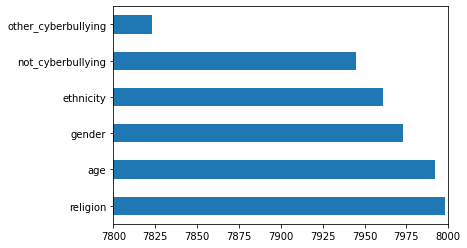

In [ ]:
#@title Text labels in dataset
df.cyberbullying_type.value_counts().plot.barh(xlim=(7800,8000))

In [ ]:
#@title Preprocessing text data, Storing to array
stopwords = [i.lower() for i in nltk.corpus.stopwords.words('english') + [chr(i) for i in range(97, 123)]]
x = df.tweet_text.apply(lambda text: re.sub("\s+", " ", ' '.join([i for i in re.sub("[^9A-Za-z ]", "" , re.sub("\\n", "", re.sub("\s+", " ", re.sub(r'http\S+', '', text.lower())))).split(" ") if i not in stopwords]))).values.astype(str)
x

array(['words katandandre food crapilicious mkr',
       'aussietv white mkr theblock imacelebrityau today sunrise studio neighbours wonderlandten etc',
       'xochitlsuckkks classy whore red velvet cupcakes', ...,
       'swear god dumb nigger bitch got bleach hair reeeeeal fuckin soon dlt fuck',
       'yea fuck rt therealexel youre nigger fucking unfollow fucking dumb niggers',
       'bro gotta chill rt chillshrammy dog fuck kp dumb nigger bitch lmao'],
      dtype='<U3182')

In [ ]:
#@title Initializing the labels from text dataset
y = pd.get_dummies(df.cyberbullying_type)
y

,age,ethnicity,gender,not_cyberbullying,other_cyberbullying,religion
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,0,1,0,0
3,0,0,0,1,0,0
4,0,0,0,1,0,0
...,...,...,...,...,...,...
47687,0,1,0,0,0,0
47688,0,1,0,0,0,0
47689,0,1,0,0,0,0
47690,0,1,0,0,0,0


In [ ]:
#@title Labels
labels = list(y.columns)
labels

['age',
 'ethnicity',
 'gender',
 'not_cyberbullying',
 'other_cyberbullying',
 'religion']

In [ ]:
#@title Spliting data into Training data and Testing data
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.4)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.25)

In [ ]:
#@title Tokenizing the text array and Converting into sequences
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=2000, oov_token="<OOV>")
tokenizer.fit_on_texts(x)
word_index = tokenizer.word_index

x_train = pad_sequences(tokenizer.texts_to_sequences(x_train), maxlen=100, padding='post', truncating='post')
x_test = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen=100, padding='post', truncating='post')
x_val = pad_sequences(tokenizer.texts_to_sequences(x_val), maxlen=100, padding='post', truncating='post')

In [ ]:
#@title Defining the text model and compiling the model
text_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(2000, 64), # embedding layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)), # LSTM layer
    tf.keras.layers.Dropout(rate=0.2), # dropout layer
    tf.keras.layers.Dense(64, activation='relu'), # fully connected layer
    tf.keras.layers.Dense(6, activation='sigmoid') # final layer
])


text_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC(curve="ROC"), tf.keras.metrics.AUC(curve="PR"),tf.keras.metrics.BinaryCrossentropy(), tf.keras.metrics.TruePositives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.PrecisionAtRecall(0.5), tf.keras.metrics.RecallAtPrecision(0.5), tf.keras.metrics.BinaryAccuracy(threshold=0.5), tf.keras.metrics.SensitivityAtSpecificity(0.5), tf.keras.metrics.SpecificityAtSensitivity(0.5)])


text_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          128000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 202,694
Trainable params: 202,694
Non-trainable params: 0
__________________________________________________

In [ ]:
#@title Training text model
#early_stopping_monitor = EarlyStopping(patience=2)
history = text_model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))#, callbacks = [early_stopping_monitor])

Epoch 1/10
895/895 [==============================] - 313s 338ms/step - loss: 0.2020 - accuracy: 0.6973 - precision: 0.8405 - recall: 0.5692 - auc: 0.9435 - auc_1: 0.8196 - binary_crossentropy: 0.2020 - true_positives: 16288.0000 - false_positives: 3092.0000 - true_negatives: 139983.0000 - false_negatives: 12327.0000 - precision_at_recall: 0.9477 - recall_at_precision: 0.8939 - binary_accuracy: 0.9102 - sensitivity_at_specificity: 0.9938 - specificity_at_sensitivity: 0.9945 - val_loss: 0.1293 - val_accuracy: 0.8077 - val_precision: 0.8610 - val_recall: 0.7507 - val_auc: 0.9786 - val_auc_1: 0.9198 - val_binary_crossentropy: 0.1293 - val_true_positives: 10740.0000 - val_false_positives: 1734.0000 - val_true_negatives: 69801.0000 - val_false_negatives: 3567.0000 - val_precision_at_recall: 0.9952 - val_recall_at_precision: 0.9879 - val_binary_accuracy: 0.9382 - val_sensitivity_at_specificity: 0.9973 - val_specificity_at_sensitivity: 0.9995
Epoch 2/10
895/895 [==============================

In [ ]:
import tensorflow as tf

# Load the model
text_model =  tf.keras.models.load_model('/content/drive/MyDrive/Project/models/cyberbullying_model_bilstm.h5')

In [ ]:
import tensorflow as tf

# Load the model
text_model =  tf.keras.models.load_model('/content/drive/MyDrive/Project/models/Bi_LSTM_Model.h5')

In [ ]:
#@title Testing data
y_test = y_test.reset_index().drop(columns=["index"]).idxmax(axis="columns").apply(labels.index).values
y_test

array([1, 4, 5, ..., 3, 2, 5])

In [ ]:
#@title Predicted data
y_pred = tf.nn.softmax(text_model.predict(x_test)).numpy().argmax(axis=1)
y_pred

150/150 [==============================] - 9s 50ms/step


array([1, 4, 5, ..., 3, 2, 5])

In [ ]:
(y_pred == y_test).mean()

0.8689727463312369

In [ ]:
#@title Classification report
print(classification_report(y_test, y_pred, target_names=labels, digits=3))

                     precision    recall  f1-score   support

                age      0.979     0.984     0.981       791
          ethnicity      0.989     0.987     0.988       785
             gender      0.915     0.868     0.891       779
  not_cyberbullying      0.751     0.612     0.674       834
other_cyberbullying      0.636     0.819     0.716       755
           religion      0.983     0.954     0.968       826

           accuracy                          0.869      4770
          macro avg      0.875     0.870     0.870      4770
       weighted avg      0.877     0.869     0.870      4770



In [ ]:
#@title Saving the model
text_model.save("/content/drive/My Drive/Project/models/cyberbullying_model_bilstm.h5")

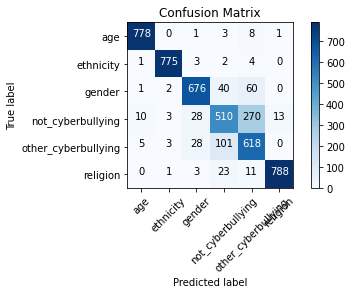

<Figure size 432x288 with 0 Axes>

In [ ]:
#@title Generating the confusion matrix
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Example usage
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=labels, title='Confusion Matrix')
fig = plt.gcf()
plt.show()
plt.draw()
fig.savefig("/content/drive/My Drive/Project/Graphs/texts/Confusion_matrix_text.png",bbox_inches = 'tight',dpi=1000)

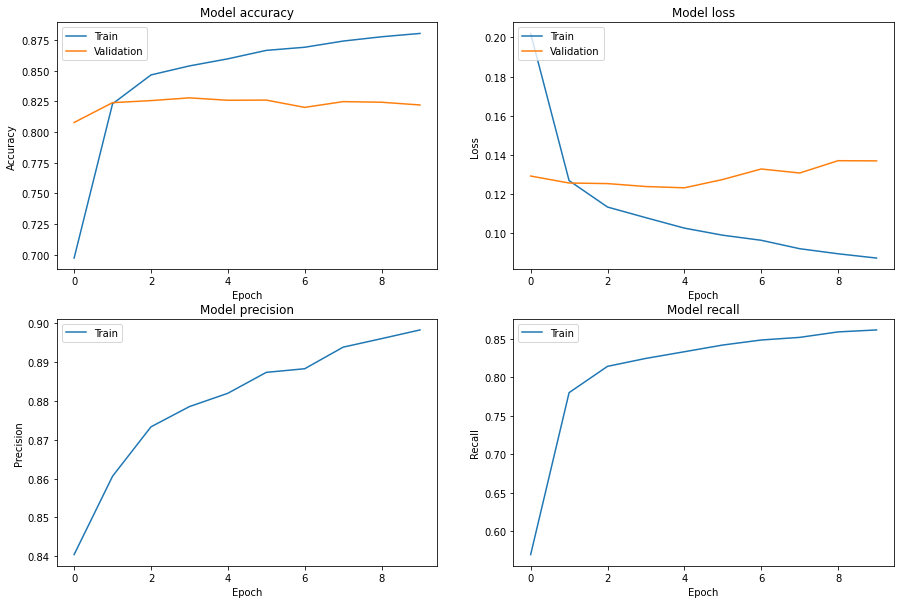

In [ ]:
import matplotlib.pyplot as plt

# Extract the metric values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
recall = history.history['recall']

# Create subplots for each metric
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Plot the accuracy
ax[0, 0].plot(acc)
ax[0, 0].plot(val_acc)
ax[0, 0].set_title('Model accuracy')
ax[0, 0].set_ylabel('Accuracy')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].legend(['Train', 'Validation'], loc='upper left')

# Plot the loss
ax[0, 1].plot(loss)
ax[0, 1].plot(val_loss)
ax[0, 1].set_title('Model loss')
ax[0, 1].set_ylabel('Loss')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].legend(['Train', 'Validation'], loc='upper left')

# Plot the precision
ax[1, 0].plot(precision)
ax[1, 0].set_title('Model precision')
ax[1, 0].set_ylabel('Precision')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].legend(['Train', 'Validation'], loc='upper left')

# Plot the recall
ax[1, 1].plot(recall)
ax[1, 1].set_title('Model recall')
ax[1, 1].set_ylabel('Recall')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].legend(['Train', 'Validation'], loc='upper left')
fig1 = plt.gcf()
plt.show()

# save the plot as an image
fig1.savefig('/content/drive/My Drive/Project/Graphs/texts/Text_Metrics_vs_epochs.jpg',bbox_inches = 'tight',dpi=1000)

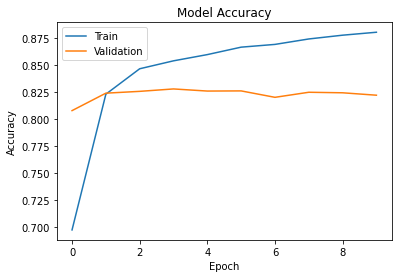

In [ ]:
# Plot line plots for accuracy and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


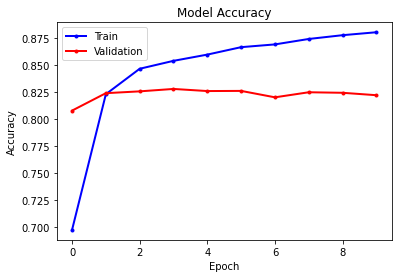

In [ ]:
# Plot line plots for accuracy and validation accuracy over epochs

plt.plot(history.history['accuracy'], marker='.', lw=2, c='b', label='Train')
plt.plot(history.history['val_accuracy'], marker='.', lw=2, c='r', label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


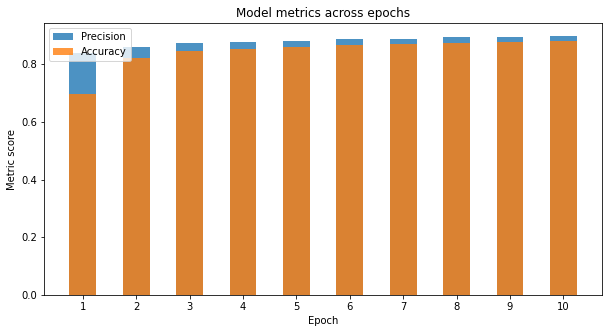

In [ ]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1, len(history.history['accuracy'])+1)]

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(epochs, history.history['precision'], width=0.5, align='center', alpha=0.8, label='Precision')
ax.bar(epochs, history.history['accuracy'], width=0.5, align='center', alpha=0.8, label='Accuracy')

ax.set_xticks(epochs)
ax.set_xlabel('Epoch')
ax.set_ylabel('Metric score')
ax.set_title('Model metrics across epochs')
ax.legend()
fig2 = plt.gcf()
plt.show()
fig2.savefig("/content/drive/My Drive/Project/Graphs/texts/Acc_pre_bar_epochs.jpg",bbox_inches = 'tight',dpi=1000)


In [ ]:
custom_input = str(input("Enter text to check whether it is bully or not"))
from textblob import TextBlob

def sentiment_analysis(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 1
    else:
        return 0

x=sentiment_analysis(custom_input)
# Preprocess the custom input text in the same way as you did for the training data
custom_input = re.sub("\s+", " ", ' '.join([i for i in re.sub("[^9A-Za-z ]", "" , re.sub("\\n", "", re.sub("\s+", " ", re.sub(r'http\S+', '', custom_input.lower())))).split(" ") if i not in stopwords]))
custom_input = tokenizer.texts_to_sequences([custom_input])
custom_input = pad_sequences(custom_input, maxlen=100, padding='post', truncating='post')

# Make the prediction using the model
prediction = text_model.predict(custom_input)

# Get the index of the highest predicted class
predicted_class_index = np.argmax(prediction)

# Get the corresponding label for the predicted class
predicted_class = labels[predicted_class_index]
def fun(arr):
  if arr in ['other_cyberbullying','gender','age','ethnicity']:
    return 0
  else:
    return 1
# print("The predicted cyberbullying type is:", fun(predicted_class) or x )
if fun(predicted_class) or x :
  print("the text is not cyber bullying")
else:
  print("the text is cyber Bullying")


In [ ]:
import json
with open("/content/drive/My Drive/Project/models/tokenizer.json", "w+") as file:
    file.write(tokenizer.to_json())

In [ ]:
import tensorflow as tf

# Load the model
text_model =  tf.keras.models.load_model('/content/drive/MyDrive/Project/models/cyberbullying_model_bilstm.h5')

In [ ]:
from sklearn.metrics import accuracy_score

bilstm_acc = accuracy_score(y_test, y_pred)
print(bilstm_acc)

0.8689727463312369
